In [1]:
from efficientnet_pytorch import EfficientNet


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *

In [4]:
model = EfficientNet.from_name('efficientnet-b5')

In [5]:
model_name = 'efficientnet-b5'
image_size = EfficientNet.get_image_size(model_name)

In [6]:
image_size

456

In [7]:
model = EfficientNet.from_pretrained(model_name)


Loaded pretrained weights for efficientnet-b5


In [8]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
np.random.seed(42)


In [10]:
src = (ImageList.from_folder(path='train-snakes-cropped').split_by_rand_pct(0.2).label_from_folder())

In [11]:
tfms=([rotate(degrees=(-90,90), p=0.8)],[])

In [12]:
bs=8

In [13]:
data = (src.transform(tfms, size=image_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs).normalize(imagenet_stats))

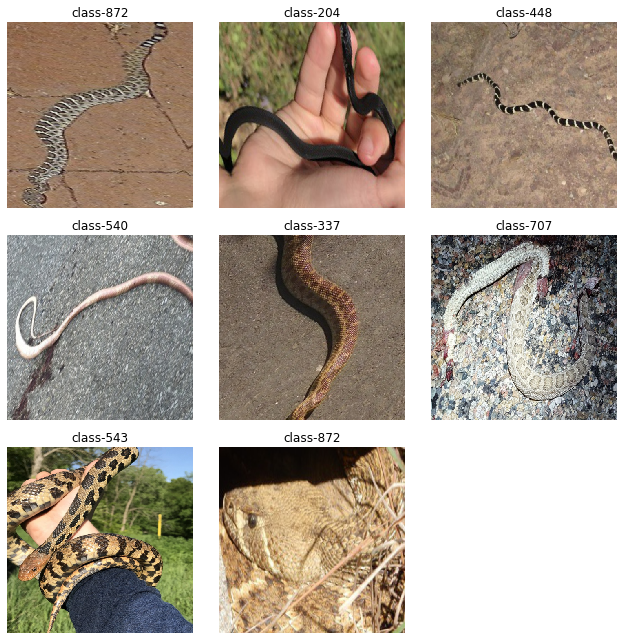

In [14]:
data.show_batch(3,figsize=(9,9))

In [15]:
list(children(model))[-2:]


[BatchNorm2d(2048, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [16]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [17]:
ef_head = create_head(2048, data.c, concat_pool=False)
ef_head = nn.Sequential(*(list(ef_head.children())[3:]))

In [18]:
model.add_module('_fc',nn.Linear(2048, data.c))
# model.add_module('_fc',ef_head)

In [19]:
loss_func =LabelSmoothingCrossEntropy()


In [20]:
RMSprop = partial(torch.optim.RMSprop)


In [21]:
from torch.optim import Optimizer

In [22]:
learn = Learner(data, model, loss_func=loss_func, opt_func=RMSprop, metrics=[accuracy,FBeta(beta=1,average='macro')])


In [23]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [24]:
learn.model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [25]:
learn.split([[learn.model._conv_stem, learn.model._bn0, learn.model._blocks[:19]],
             [learn.model._blocks[19:],learn.model._conv_head], 
             [learn.model._bn1,learn.model._fc]])

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [26]:
learn.summary()

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 457, 457]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 230, 230]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 228, 228]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 228, 228]       0          False     
_________________________________________________

In [27]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


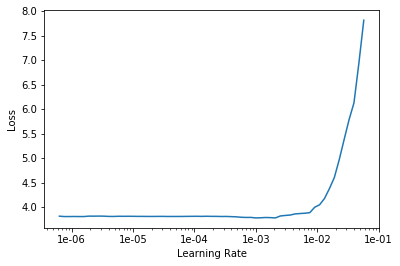

In [28]:
learn.recorder.plot()

In [29]:
lr=1e-3

In [30]:
learn.fit_one_cycle(2,max_lr=slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.865044,1.695083,0.715404,0.643587,48:09
1,1.344886,1.264867,0.822605,0.783601,48:15


In [31]:
learn.save('b0-round-1')

In [ ]:
learn.fit_one_cycle(20,max_lr=slice(lr/1000,lr/100))

In [ ]:
learn.save('b0-round-2')

In [32]:
learn.save('b7-round-1')

In [34]:
learn.load('b7-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65932 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train-snakes-cropped;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
class-540,class-72,class-771,class-4,class-804
Path: train-snakes-cropped;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_pad

In [35]:
learn.validate()

[1.2648666, tensor(0.8226), tensor(0.7907)]

In [39]:
learn = learn.to_fp32()

In [40]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 2.12 MiB (GPU 0; 15.75 GiB total capacity; 14.17 GiB already allocated; 2.88 MiB free; 68.03 MiB cached)